# PROYECTO 3: ANTI-PHISHING
Daniela Gil y Sofia Ochoa

El phishing consiste en engañar al usuario mediante una copia de una página web legítima o a través de comunicaciones por email o mensajería en las que se suplanta la identidad de la empresa original y se le solicita al usuario la introducción de su información personal. El proyecto implementa una estrategia de anti-phishing que pretende identificar si un URL de una pagina web es phishing, tomado de [Phishing Dataset for Machine Learning](https://www.kaggle.com/datasets/shashwatwork/phishing-dataset-for-machine-learning?resource=download).




Primero, se importan las librerias necesarias.

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB

import matplotlib.colors as colors
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

Se importa el dataset.

In [ ]:
df = pd.read_csv("Phishing_Legitimate_full.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

In [ ]:
df['CLASS_LABEL'].value_counts()

1    5000
0    5000
Name: CLASS_LABEL, dtype: int64

El dataset tiene 50 columnas, y como se puede observar la columna objetivo es 'CLASS_LABEL' la cual toma valores 0 y 1, que representan si el URL de la página es phishing.

Se eliminan las columnas 'SubdomainLevelRT', 'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT' ya que es información repetida en el dataset. De igual manera 'id' ya que es una columna de tipo índice que no brinda información y 'HttpsInHostname' porque tiene un único valor en toda la columna.

In [ ]:
df = df.drop(columns=['HttpsInHostname', 'id', 'SubdomainLevelRT', 'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT'])

Se separa el dataset en X y.

In [ ]:
X = df.drop('CLASS_LABEL', axis=1)
y = df['CLASS_LABEL']

# Recursive Feature Elimination with Cross-Validation

Se usará Recursive Feature Elimination with Cross-Validation(RFECV) que utiliza validación cruzada para determinar automáticamente el número óptimo de características a seleccionar. Esto se hace para reducir la dimensionalidad de los datos,  eliminando iterativamente las características menos relevantes.
Se crea una instancia de RFECV utilizando un clasificador DecisionTreeClassifier como estimador:

In [ ]:
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)]) #Se crea un pipeline que encadena el selector de características (rfe) y el clasificador (model):

Se evalúa el rendimiento del modelo utilizando RepeatedStratifiedKFold con 10 divisiones (n_splits=10) y 3 repeticiones (n_repeats=3):

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores))) #Se imprime el rendimiento del modelo en términos de exactitud media y desviación estándar

Accuracy: 0.966 (0.007)


Se imprimen las columnas que el RFECV seleccionó como las mejores características.

In [ ]:
pipeline.fit(X, y) # Entrenar el modelo RFECV
rfe = pipeline.named_steps['s'] # Obtener el objeto RFECV del pipeline
selected_columns = X.columns[rfe.support_] # Obtener las columnas seleccionadas
print("Columnas seleccionadas:") # Imprimir las columnas seleccionadas
for column in selected_columns:
    print(column)

Columnas seleccionadas:
NumDots
SubdomainLevel
PathLevel
UrlLength
NumDash
NumDashInHostname
NumUnderscore
NumPercent
NumQueryComponents
NumAmpersand
NumNumericChars
NoHttps
DomainInPaths
HostnameLength
PathLength
QueryLength
NumSensitiveWords
PctExtHyperlinks
PctExtResourceUrls
ExtFavicon
InsecureForms
RelativeFormAction
ExtFormAction
AbnormalFormAction
PctNullSelfRedirectHyperlinks
FrequentDomainNameMismatch
SubmitInfoToEmail
IframeOrFrame
ImagesOnlyInForm


Se puede observar que por medio de RFECV se disminuyeron el número de columnas a 29, quedando con las siguientes características:

*   NumDots(Discreta): Cuenta el número de puntos en la URL.
*   SubdomainLevel(Discreta): Cuenta el nivel de Subdomain en la URL.
*   PathLevel(Discreta): Cuenta la profundidad de la ruta en la URL de la página web.
*   UrlLength(Discreta): Cuenta el número total de caracteres en la URL.
*   NumDash(Discreta): Cuenta el número de “-” en la URL  de la página web.
*   NumDashInHostname(Discreta): Cuenta el número de “-” en el hostname de la URL.
*   NumUnderscore(Discreta): Cuenta el número de “_”  en la URL.
*   NumPercent(Discreta):Cuenta el número de “%” en la URL.
*   NumQueryComponents(Discreta): Cuenta el número de querys en la URL.
*   NumAmpersand(Discreta): Cuenta el número de “&” en la URL.
*   NumNumericChars(Discreta): Cuenta el número de caracteres numéricos en la URL.
*   NoHttps(Binaria): Indica si HTTPS está en la URL.
*   DomainInPaths(Binaria): Indica si TLD o ccTLD es usado en el path de la URL.
*   HostnameLength(Discreta): Cuenta la cantidad de carácteres en la parte del nombre del host de la URL.
*   PathLenght(Discreta): Cuenta el total de carácteres en la ruta de la URL.
*   QueryLenght(Discreta): Cuenta el número total de carácteres en la parte de la consulta de la URL.
*   NumSensitiveWords(Discreta): Cuenta la cantidad de palabras confidenciales (es decir, "seguro", "cuenta", "webscr", "iniciar sesión", "ebayisapi", "iniciar sesión", "banca", "confirmar") en la URL de la página web.
*   PctExtHyperlinks(Continua): Cuenta el porcentaje de hipervínculos externos en el código fuente HTML de la URL.
*   PctExtResourceUrls(Continua): Cuenta el porcentaje de direcciones URL de recursos externos en el código fuente HTML de la página web.
*   ExtFavicon(Binaria): Indica si el favicon se carga desde un nombre de dominio diferente del nombre de dominio de la URL.
*   InsecureForms(Binaria): Indica si el atributo de acción de formulario contiene una dirección URL sin protocolo HTTPS
*   RelativeFormAction(Binaria): Indica si el atributo de acción del formulario contiene una URL relativa.
*   ExtFormAction(Binaria): Indica si el atributo de acción del formulario contiene una dirección URL de un dominio externo.
*   AbnormalFormAction(Categórica): Indica si el atributo de acción del formulario contiene un "#", "about: blanc", una cadena vacía o "javascript:true"
*   PctNullSelfRedirectHyperlinks(Continua): Cuenta el porcentaje de campos de hipervínculos que contienen valor vacío, valor de autoredireccionamiento como "#", la dirección URL de la página web actual o algún valor anormal como "file://E:/"
*   FrequentDomainNameMismatch(Binaria): Indica si el código fuente HTML contiene el comando JavaScript onMouseOver para mostrar una URL falsa en la barra de estado.
*   SumbitInfoToEmail(Binaria): Indica si el código fuente HTML contiene la función “mailto”.
*   IframeOrFram(Binaria): Comprueba si se usa iframe o frame en el código fuente HTML.
*   ImagesOnlyInForm(Binaria): Indica si el ámbito del formulario en el código fuente HTML no contiene texto en absoluto, sino sólo imágenes.



Se establece un nuevo dataframe con solo estas caracteristicas:

In [ ]:
x = df[['NumDots','SubdomainLevel','PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand','NumNumericChars', 'NoHttps', 'DomainInPaths', 'HostnameLength', 'PathLength', 'QueryLength', 'NumSensitiveWords', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'SubmitInfoToEmail', 'IframeOrFrame', 'ImagesOnlyInForm', 'CLASS_LABEL']]

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   NumDots                        10000 non-null  int64  
 1   SubdomainLevel                 10000 non-null  int64  
 2   PathLevel                      10000 non-null  int64  
 3   UrlLength                      10000 non-null  int64  
 4   NumDash                        10000 non-null  int64  
 5   NumDashInHostname              10000 non-null  int64  
 6   NumUnderscore                  10000 non-null  int64  
 7   NumPercent                     10000 non-null  int64  
 8   NumQueryComponents             10000 non-null  int64  
 9   NumAmpersand                   10000 non-null  int64  
 10  NumNumericChars                10000 non-null  int64  
 11  NoHttps                        10000 non-null  int64  
 12  DomainInPaths                  10000 non-null  

# Red Neuronal

Se separa el dataset en train, test y validation.

In [ ]:
x_train_val, x_test, _, _ = train_test_split(x, x, test_size=0.1, random_state=42)
x_train, x_val, _, _ = train_test_split(x_train_val, x_train_val, test_size=0.1, random_state=42)

Ahora definimos la clase 'MyDataset' para convertir los datos de los atributos y la variable objetivo a parejas ordenadas de tensores y así alimentar la red neuronal.

In [ ]:
class MyDataset():

  def __init__(self,df,target_column):
    y=df[target_column].values
    X=df.drop(target_column,axis=1).values
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)


  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

Hacemos uso de la clase MyDataset para convertir cada conjunto definido anteriormente a tensores. En este caso, le mandamos como atributos el respectivo conjunto y la variable objetivo.

In [ ]:
train_sec=MyDataset(x_train, 'CLASS_LABEL')
test_sec=MyDataset(x_test,'CLASS_LABEL')
val_sec=MyDataset(x_val,'CLASS_LABEL')

Definimos los dataloaders para procesar los datos y alimentar a la red neuronal por lotes. Lo hicimos con batch_size = 3 para el train y el validation. Para el test con batch_size = 1.

In [ ]:
train_data=DataLoader(
    train_sec,
    batch_size=3,
    shuffle=False,
 )

test_data=DataLoader(
    test_sec,
    batch_size=1,
    shuffle=False,
 )

val_data=DataLoader(
    val_sec,
    batch_size=3,
    shuffle=False,
 )

Se crea la clase Net que define la arquitectura de la red neuronal. Tiene dos capas oculta con 15 y 3 nodos. Como función de activación se usó la función sigmoide, por eso no fue necesario estandarizar los datos.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(29, 15)
        self.fc2 = nn.Linear(15, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        # Do the forward pass
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x

Se define el modelo, el optimizador y la función de costo. Se usó un learning rate de 0.001. Como función de costo se usó BinaryCrossEntropyLoss ya que es un problema de clasificación binario y se adapta mejor a este tipo de problemas.

In [ ]:
model=Net()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion=nn.BCELoss()

Ahora se entrena el modelo con num_epochs = 10.

In [ ]:
def train_model(model,optimizer,loss_module,train_loader,valid_loader,num_epochs=20):

  valid_loss_min = np.inf  #Vamos a encontrar el menor valor de error de validación. Por eso la inicializamos como 'infinito'

  for i in range(num_epochs):
    model.train()  #Ponemos el modelo en modo entrenamiento
    train_loss = 0.0
    v_loss = 0.0

    for data, target in train_loader:
        #Se reinician los gradientes
        optimizer.zero_grad()
        #Forward pass: calcular la salida para los datos de entrada..
        preds = model(data)
        preds = preds.squeeze(dim=1)
        #Calculate the batch loss
        loss = loss_module(preds, target)
        #Backpropagation: cálculo de gradientes
        loss.backward()
        #Actualizar los parámetros
        optimizer.step()
        #Actualizar la cuenta de costos a lo largo de los lotes
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('train_loss:')
    print(train_loss)

    model.eval() #Ponemos el modelo en modo evaluación.
    #Vamos a evaluar el modelo entrenado, calculando predicciones con el conjunto de validación
    for data,target in valid_loader:
        output=model(data)
        target=target.view(3,-1)
        valid_loss= loss_module(output, target)
        valid_loss += valid_loss.item()*data.size(0)
    valid_loss = valid_loss/len(valid_loader.dataset)
    #Imprimir estadísticas de entrenamiento y validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        i, train_loss, valid_loss))


    #Guardamos el modelo con el menor error de validación.
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'proyecto.pt')
        valid_loss_min = valid_loss

In [ ]:
train_model(model,optimizer,criterion,train_data,val_data)

train_loss:
0.5345239518472442
Epoch: 0 	Training Loss: 0.534524 	Validation Loss: 0.000982
Validation loss decreased (inf --> 0.000982).  Saving model ...
train_loss:
0.26084560903686066
Epoch: 1 	Training Loss: 0.260846 	Validation Loss: 0.000344
Validation loss decreased (0.000982 --> 0.000344).  Saving model ...
train_loss:
0.19409980064809873
Epoch: 2 	Training Loss: 0.194100 	Validation Loss: 0.000186
Validation loss decreased (0.000344 --> 0.000186).  Saving model ...
train_loss:
0.17448834239332764
Epoch: 3 	Training Loss: 0.174488 	Validation Loss: 0.000158
Validation loss decreased (0.000186 --> 0.000158).  Saving model ...
train_loss:
0.16453255306584416
Epoch: 4 	Training Loss: 0.164533 	Validation Loss: 0.000132
Validation loss decreased (0.000158 --> 0.000132).  Saving model ...
train_loss:
0.15832865602026383
Epoch: 5 	Training Loss: 0.158329 	Validation Loss: 0.000115
Validation loss decreased (0.000132 --> 0.000115).  Saving model ...
train_loss:
0.15414127178352188
Ep

Se imprime el test_loss.

In [ ]:
test_loss=0.0
criterion= nn.BCELoss()
for data, target in test_data:
  output=model(data)
  target=target.view(1,-1)
  loss= criterion(output,target)
  test_loss += loss.item()*data.size(0)
test_loss = test_loss/len(test_data.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.165860



In [ ]:
model.eval()
total, correct = 0, 0

for i, data in enumerate(test_data, 0):
    inputs, labels = data[0], data[1]
    outputs = model(inputs)
    predicted = torch.round(outputs).squeeze()
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

In [ ]:
print('El accuracy del test de la red es: %d %%' % (100 * correct / total))

El accuracy del test de la red es: 94 %


Usaremos la metrica F1 para evaluar el modelo, ya que la idea del modelo es determinar cuando una URL es phishing, y se debe lograr un equilibrio entre precision y sensitivity. Se debe clasificar correctamente URL de paginas web que sean phishing (sensitivity) al mismo tiempo que evita la clasificación incorrecta de URL legítimos como phising (precision).

In [ ]:
model.eval()
true_positives = 0
false_positives = 0
false_negatives = 0

for i, data in enumerate(test_data, 0):
    inputs, labels = data[0], data[1]
    outputs = model(inputs)
    predicted = torch.round(outputs).squeeze()

    true_positives += ((predicted == 1) & (labels == 1)).sum().item()
    false_positives += ((predicted == 1) & (labels == 0)).sum().item()
    false_negatives += ((predicted == 0) & (labels == 1)).sum().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print('Precision:', precision)
print('Recall:', recall)

Precision: 0.9127134724857685
Recall: 0.9776422764227642


In [ ]:
f1 = 2 * (precision * recall) / (precision + recall)
print('F1:', f1)

F1: 0.9440628066732091


Los valores del accuracy y F1 indican que es un buen modelo y tiene un alto rendimiento. No se exploraron todas las posibilidades de variacion de hiperparametros, ya que al hacerlo con estos se obtuvo un rendimiento bastante bueno, pero para mejorar este rendimiento y que se obtenga un modelo muy preciso, se pueden cambiar estos hiperparametros.

# Random Forest

Ahora se entrenara un modelo con random forest. Separamos la columna objetivo y dividimos el dataset en train y test con una proporcion de 70% y 30%

In [ ]:
X = x.drop('CLASS_LABEL', axis=1)
y = x['CLASS_LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Usamos la funcion RandomForestClassifier de sklearn y se entrena el modelo con el train.

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

Se realizan predicciones del modelo sobre los datos de prueba.

In [ ]:
y_pred = rf.predict(X_test)

Se comparan las etiquetas verdaderas (y_test) con las etiquetas predichas (y_pred) y calcula la precisión y F1 del modelo como el porcentaje de muestras en las que las etiquetas predichas coinciden con las etiquetas verdaderas.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1-score:", f1)

Accuracy: 0.979
F1-score: 0.979187314172448


Estos resultados indican que el modelo Random Forest ha logrado una clasificación precisa y un buen equilibrio entre la precisión y la exhaustividad en el conjunto de datos de prueba.

# SVM

Se divide el dataset en train y test con una proporcion de 70% y 30% y se estandariza independientemente para X_train y X_test, para que el conjunto de testeo no contenga ningún tipo de información sobre el train set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Se buscan los mejores parámetros 'C' y 'gamma' para el clasificador SVC utilizando Grid Search Cross Validation.

In [ ]:
num_features = np.size(X_train, axis=1)
param_grid = [
  {'C': [1, 10, 100, 1000],
   'gamma': [1/num_features, 1, 0.1, 0.01, 0.001, 0.0001],
   'kernel': ['rbf']},
]
optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='roc_auc',
        verbose=0
    )
optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.034482758620689655, 'kernel': 'rbf'}


Se entrena un clasificador de Máquina de Soporte Vectorial con los parametros encontrados anteriormente.

In [ ]:
clf = SVC(kernel = 'rbf', gamma= 0.034482758620689655, C=10)
clf.fit(X_train, y_train)

SVC(C=10, gamma=0.034482758620689655)

Se calculan las metricas Accuracy y F1 score con las funciones de sklearn. Se realiza la predicción de etiquetas utilizando el clasificador clf en los datos de prueba X_test. El resultado se guarda en la variable y_pred y se compara con las etiquetas verdaderas y_test para hallar estas metricas.


In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1 score:", f1)

Accuracy: 0.9676666666666667
F1 score: 0.9679973606070603


Los resultados obtenidos indican que el modelo SVM ha logrado un buen rendimiento en términos de clasificación precisa en el conjunto de datos de prueba.

# KNN

Se separa el dataset en train y test, en una proporción de 70%, 30%.

In [ ]:
#Separamos la columna objetivo
X = x.drop('CLASS_LABEL', axis=1)
y = x['CLASS_LABEL']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=0,test_size=0.3, shuffle=True)

Importamos el classificador KNeighborsClassifier de SKLearn con el nombre *knn* y usamos k=3. También, entrenamos el clasificador con los datos de entrenamiento.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

Calculamos el accuracy y F1 con las funciones de sklearn.

In [ ]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1 score:", f1)

Accuracy: 0.8526666666666667
F1 score: 0.8586052463211772


Ahora entrenamos clasificadores de KNN con diferentes valores de k y visualizaremos el cambio entre ellos.

In [ ]:
scores = []
for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    scores.append(knn.score(X_test, y_test))

El mejor rendimiento se obtuvo con n=3. Los datos están bien estructurados y separables en grupos distintos en el espacio de características, por lo que no es necesario evaluar muchos vecinos ya que con solo la información de algunos se obtiene una buena deducción acerca de los nuevos datos. Al usar un k más grande se empieza a perder precision.

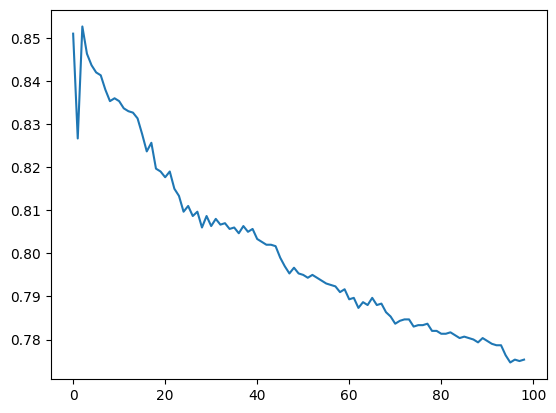

In [ ]:
plt.plot(scores)

Como podemos observar en la gráfica a medida que va aumentando el k, la exactitud del modelo disminuye. Esto se debe a la agrupacion de los datos por lo que no es necesarios tener un número de vecinos tan grande. A medida que se consideran más vecinos, aumenta el sesgo y también se incluyen muestras que pueden estar más lejos del punto de interés y pueden contener ruido, de igual manera comienza a generalizar en exceso y tratar todas las muestras de manera similar.
Pero de igual manera, el rendimiento no es el mejor, por lo que este modelo puede no ser el optimo para el dataset.

# Naive Bayes Classifier

Se separa el dataset en train y test, en una proporción de 67%, 33%.

In [ ]:
#Separamos la columna objetivo
X = x.drop('CLASS_LABEL', axis=1)
y = x['CLASS_LABEL']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=125)

Entrenamos el clasificador en el conjunto de datos de entrenamiento utilizando hiperparámetros predeterminados.

In [ ]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

Usaremos la precisión y la métrica f1 para determinar el rendimiento del modelo.

In [ ]:
y_pred = model.predict(X_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.863030303030303
F1 Score: 0.8640492175182672


Estos valores indican un rendimiento aceptable en términos de clasificación precisa.

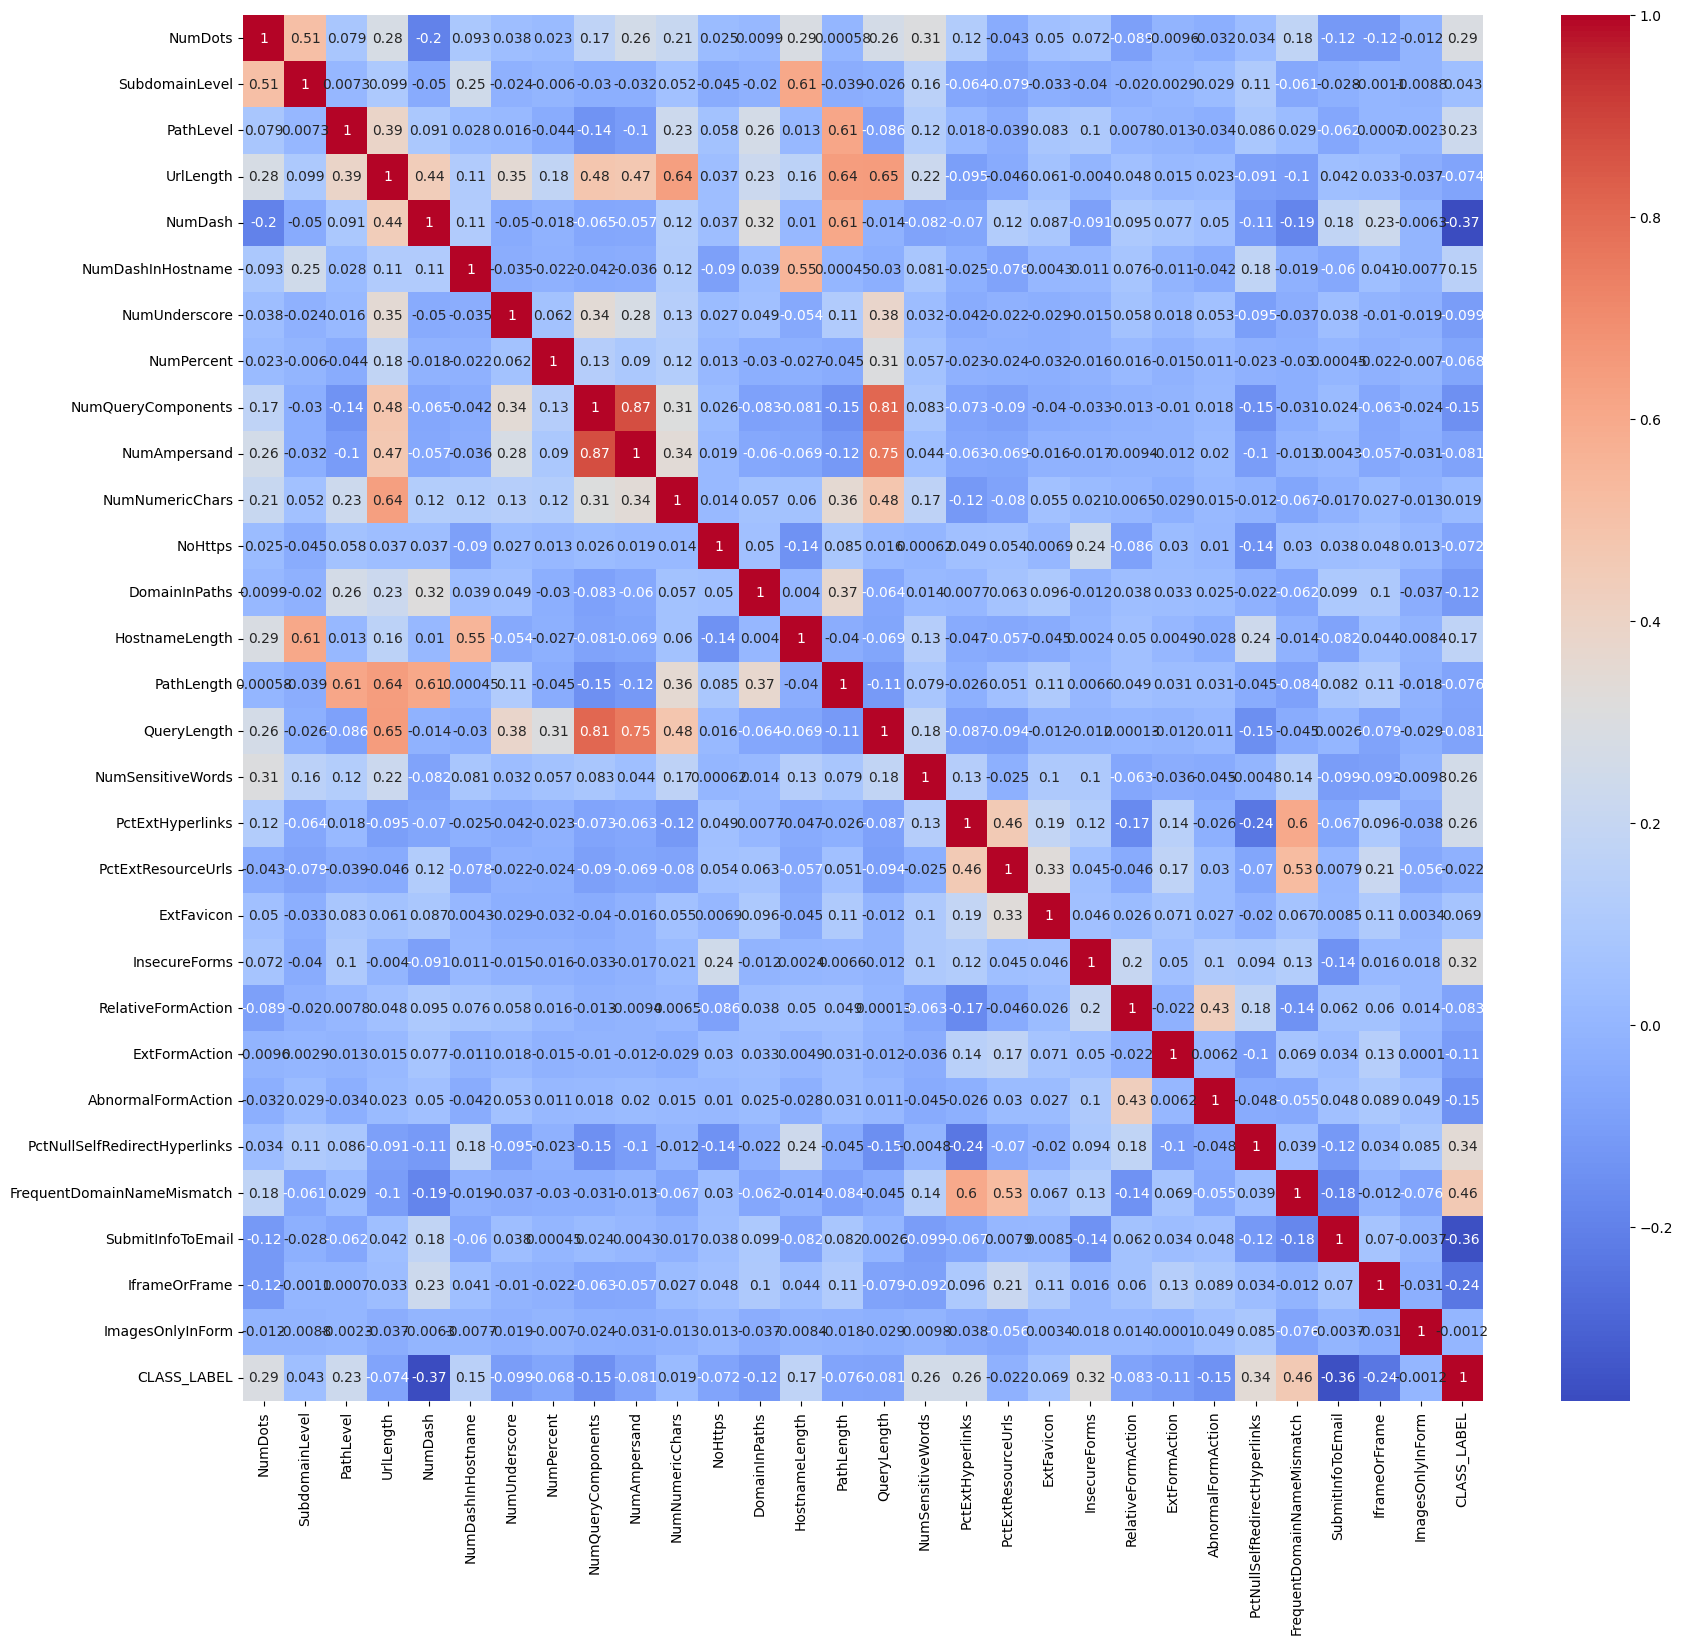

In [ ]:
matriz_correlacion = x.corr()
import seaborn as sns
plt.figure(figsize=(20, 18))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.show()

No se obtuvo un rendimiento tan alto ya que hay una alta correlación entre algunas de las características del conjunto de datos y esto puede violar la suposición de independencia en el modelo Naive Bayes Gaussiano, por lo que, el modelo puede no capturar adecuadamente las relaciones entre las características y, como resultado, el accuracy y el F1-score pueden disminuir.

# Conclusiones

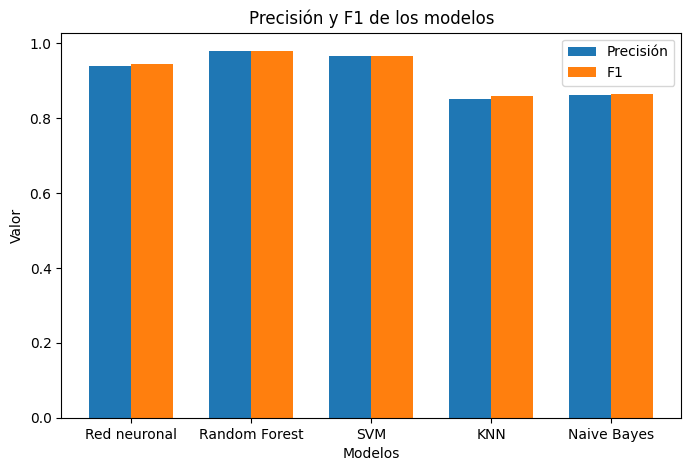

In [ ]:
model_names = ["Red neuronal", "Random Forest", "SVM", "KNN", "Naive Bayes"]
accuracy_values = [0.94, 0.979, 0.967, 0.852, 0.863]
f1_values = [0.944, 0.979, 0.967, 0.858, 0.864]
plt.figure(figsize=(8, 5))
bar_width = 0.35
r1 = np.arange(len(accuracy_values))
r2 = [x + bar_width for x in r1]
plt.bar(r1, accuracy_values, width=bar_width, label='Precisión')
plt.bar(r2, f1_values, width=bar_width, label='F1')
plt.xlabel("Modelos")
plt.ylabel("Valor")
plt.title("Precisión y F1 de los modelos")
plt.xticks([r + bar_width/2 for r in range(len(accuracy_values))], model_names)
plt.legend()
plt.show()

Como podemos darnos cuenta, en los 5 algoritmos de clasificación binaria que se implementaron, se obtuvieron valores altos para todas las métricas con las que se midió el desempeño de cada uno de los modelos (accuracy, F1). Esto implica que el modelo es capaz de realizar predicciones precisas y consistentes en la
tarea de clasificación.

El algoritmo con el que mejor desempeño se obtuvo para este dataset fue el de Random Forest ya que con este se obtuvo un acurracy del 97%. Esto se puede deber a que este algoritmo logra capturar relaciones no lineales y complejas en los datos de clasificación binaria además de manejar conjuntos de datos grandes de manera  eficiente y proporcionar una medida de la importancia de las características utilizadas en el proceso de clasificación, por lo que es ideal para este dataset en específico, ya que en este se trabaja con una cantidad de datos bastante grandes y varias características. De igual manera, mejorar la red neuronal puede dar valores aun mas cercanos a 1 de las metricas.

Los modelos de Random Forest, SVM y la red neuronal muestran un rendimiento superior en términos de precisión y capacidad de clasificación en comparación con KNN y Naive Bayes. Sin embargo, es importante considerar otros factores, como el tiempo de entrenamiento y la interpretabilidad del modelo, al seleccionar el modelo más adecuado para un problema específico.

En conclusion, el dataset es propicio para el aprendizaje automático y contiene patrones distintivos que los modelos son capaces de capturar y utilizar para realizar predicciones precisas. Los datos tienen una estructura clara y significativa, lo que facilita la tarea de clasificación. Esta consistencia en el rendimiento también proporciona más confianza en los resultados obtenidos, ya que diferentes modelos aplicados al mismo conjunto de datos están llegando a conclusiones similares y logrando un buen desempeño.